In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# a. Import the datasets
restaurants = pd.read_csv('resturants.csv')
items = pd.read_csv('items.csv')
sales = pd.read_csv('sales.csv')

# b. Examine the datasets
print("Restaurants DataFrame Shape and Head:\n", restaurants.shape, restaurants.head())
print("Items DataFrame Shape and Head:\n", items.shape, items.head())
print("Sales DataFrame Shape and Head:\n", sales.shape, sales.head())

# c. Merge the datasets
merged_df = sales.merge(items, left_on='item_id', right_on='id', how='left')\
                  .merge(restaurants, left_on='store_id', right_on='id', how='left')\
                  .rename(columns={'name_x': 'item_name', 'cost': 'item_cost', 'kcal': 'item_kcal', 'name_y': 'store_name'})

print("Merged DataFrame Shape and Head:\n", merged_df.shape, merged_df.head())


Restaurants DataFrame Shape and Head:
 (6, 2)    id            name
0   1     Bob's Diner
1   2  Beachfront Bar
2   3     Sweet Shack
3   4        Fou Cher
4   5     Corner Cafe
Items DataFrame Shape and Head:
 (100, 5)    id  store_id                               name  kcal   cost
0   1         4                     Chocolate Cake   554   6.71
1   2         4  Breaded Fish with Vegetables Meal   772  15.09
2   3         1                  Sweet Fruity Cake   931  29.22
3   4         1    Amazing Steak Dinner with Rolls   763  26.42
4   5         5                          Milk Cake   583   6.07
Sales DataFrame Shape and Head:
 (109600, 4)          date  item_id  price  item_count
0  2019-01-01        3  29.22         2.0
1  2019-01-01        4  26.42        22.0
2  2019-01-01       12   4.87         7.0
3  2019-01-01       13   4.18        12.0
4  2019-01-01       16   3.21       136.0
Merged DataFrame Shape and Head:
 (109600, 11)          date  item_id  price  item_count  id_x  sto

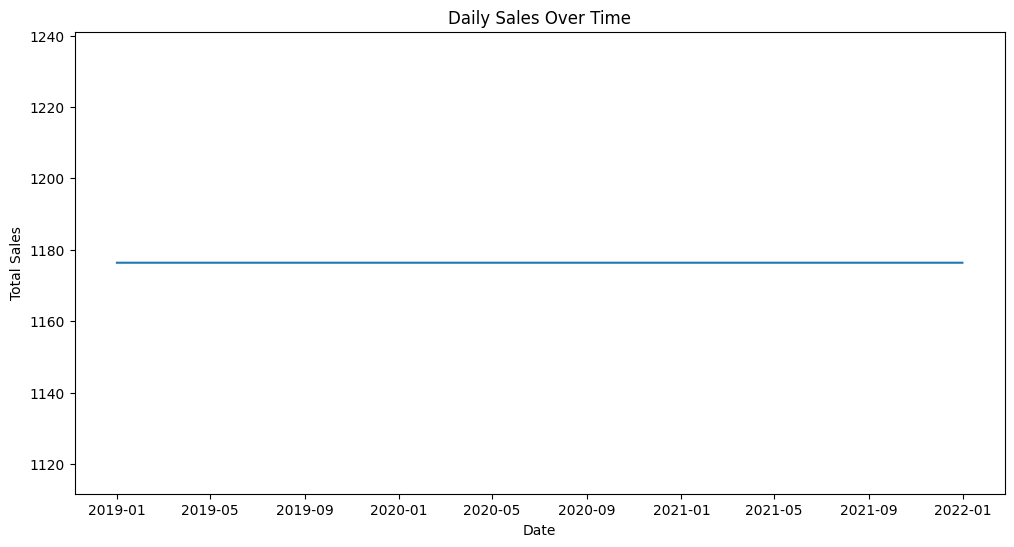

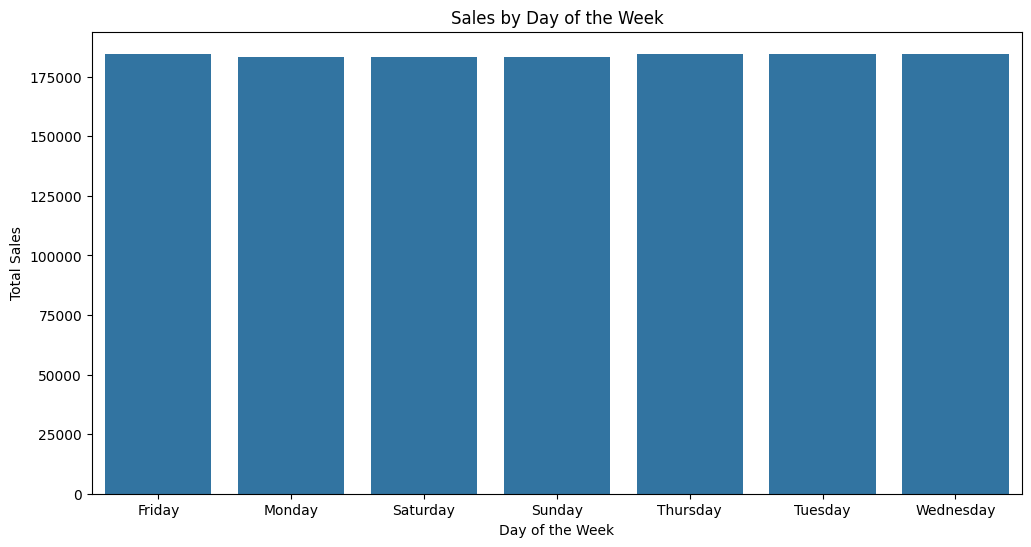

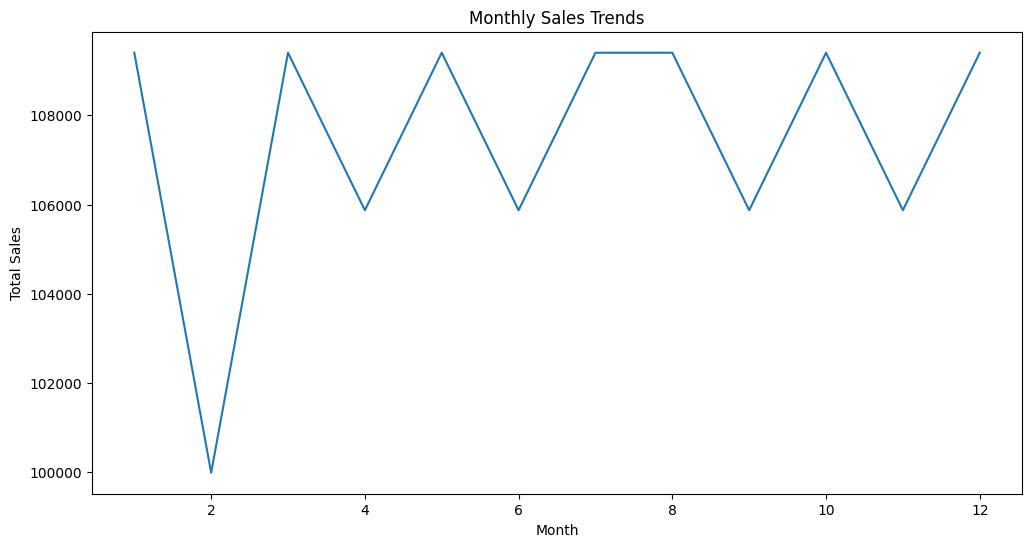

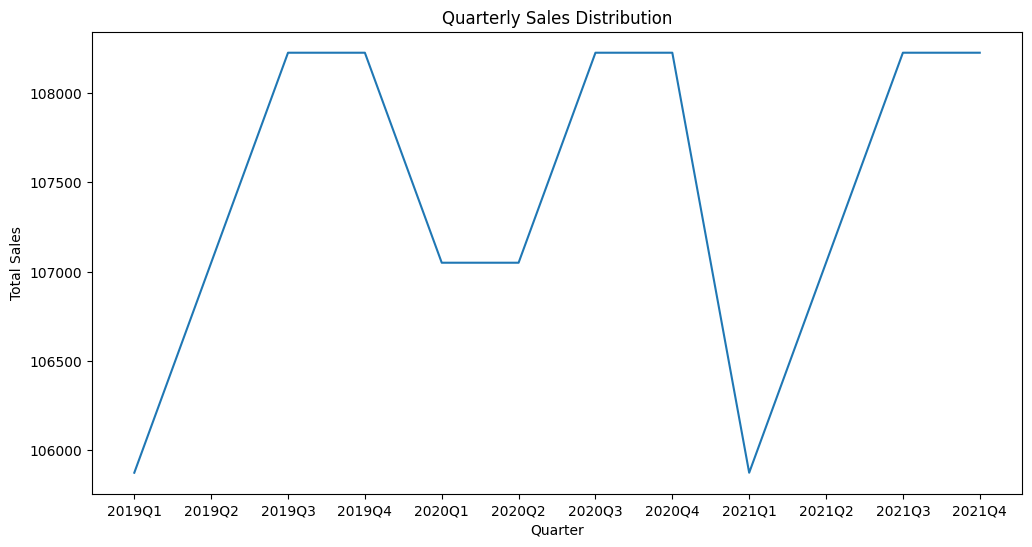

Restaurant with the most sales: Fou Cher


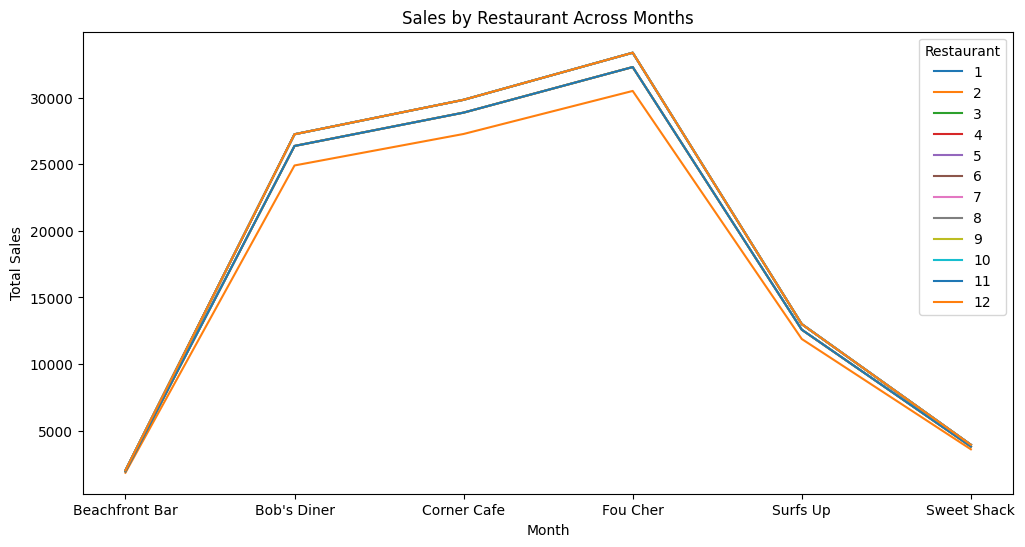

Most popular items:
                                             item_name     price
27                      Blue Ribbon Fruity Vegi Lunch  59162.08
89                                  Sweet Fruity Cake  32025.12
83                    Sea Bass with Vegetables Dinner  31510.00
72  Original Fruity Cod with Bread and Vegetables ...  31400.40
91                                  Sweet Savory Cake  30107.12
4                     Amazing Steak Dinner with Rolls  28956.32
80                                         Pike Lunch  28901.52
84                                         Steak Meal  28726.16
13                       Awesome Hamburger with Fries  28539.84
7                Amazing Trout with Vegetables Dinner  27378.08
Store Fou Cher average sales per day: 358.94999999999993
Store Fou Cher total sales volume: 393409.19999999995
Most expensive item: Blue Ribbon Fruity Vegi Lunch with calorie count: 881


In [2]:
# Exploratory Data Analysis

# Convert 'date' to datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

# a. Examine overall date-wise sales
daily_sales = merged_df.groupby('date')['price'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['date'], daily_sales['price'])
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

# b. Sales fluctuations across different days of the week
merged_df['day_of_week'] = merged_df['date'].dt.day_name()
weekly_sales = merged_df.groupby('day_of_week')['price'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='price', data=weekly_sales)
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.show()

# c. Sales trends by month
merged_df['month'] = merged_df['date'].dt.month
monthly_sales = merged_df.groupby('month')['price'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['month'], monthly_sales['price'])
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

# d. Sales distribution by quarter
merged_df['quarter'] = merged_df['date'].dt.to_period('Q')
quarterly_sales = merged_df.groupby('quarter')['price'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(quarterly_sales['quarter'].astype(str), quarterly_sales['price'])
plt.title('Quarterly Sales Distribution')
plt.xlabel('Quarter')
plt.ylabel('Total Sales')
plt.show()

# e. Compare performances of different restaurants
restaurant_sales = merged_df.groupby('store_name')['price'].sum().reset_index()
top_restaurant = restaurant_sales.sort_values(by='price', ascending=False).iloc[0]
print(f"Restaurant with the most sales: {top_restaurant['store_name']}")

# Sales by restaurant across different periods
restaurant_sales_by_month = merged_df.groupby(['store_name', 'month'])['price'].sum().unstack().fillna(0)
restaurant_sales_by_month.plot(figsize=(12, 6))
plt.title('Sales by Restaurant Across Months')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Restaurant')
plt.show()

# f. Most popular items and stores
item_sales = merged_df.groupby('item_name')['price'].sum().reset_index()
top_items = item_sales.sort_values(by='price', ascending=False).head(10)
print("Most popular items:\n", top_items)

# g. Store with highest sales volume vs. sales per day
top_store = top_restaurant['store_name']
store_sales = merged_df[merged_df['store_name'] == top_store]
store_sales_per_day = store_sales.groupby('date')['price'].sum().mean()
store_sales_volume = store_sales['price'].sum()
print(f"Store {top_store} average sales per day: {store_sales_per_day}")
print(f"Store {top_store} total sales volume: {store_sales_volume}")

# h. Most expensive item and its calorie count
expensive_items = merged_df.groupby('item_name').agg({'item_cost': 'max'}).reset_index()
most_expensive_item = expensive_items.sort_values(by='item_cost', ascending=False).iloc[0]
most_expensive_item_name = most_expensive_item['item_name']
calories = items[items['id'].isin(merged_df[merged_df['item_name'] == most_expensive_item_name]['item_id'])]['kcal'].values[0]
print(f"Most expensive item: {most_expensive_item_name} with calorie count: {calories}")


Linear Regression RMSE: 8.946184511287479
Random Forest RMSE: 8.94659321233263
XGBoost RMSE: 8.946184511287491


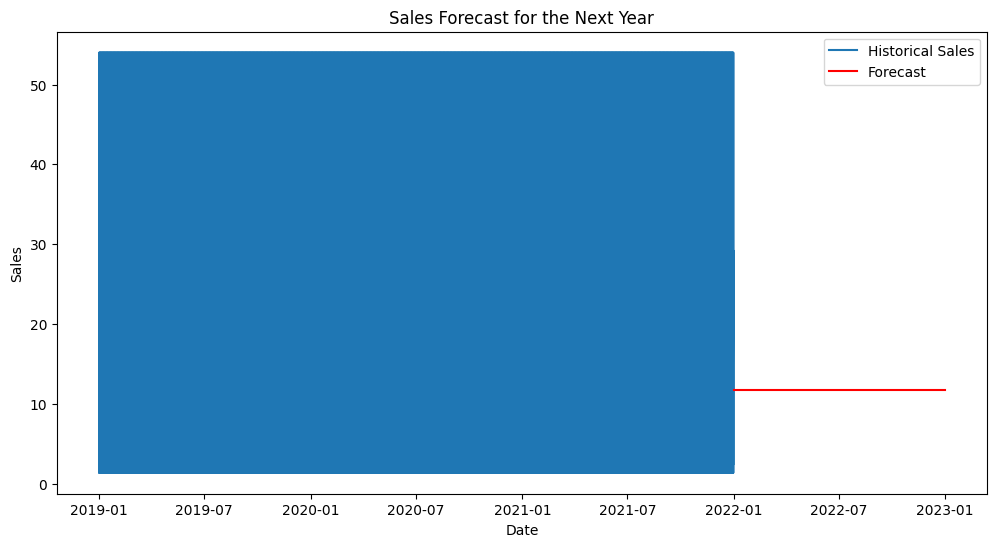

In [3]:
#Forecasting using Machine Learning Algorithm

# Prepare features for ML models
merged_df['day_of_week'] = merged_df['date'].dt.dayofweek
merged_df['month'] = merged_df['date'].dt.month
merged_df['year'] = merged_df['date'].dt.year
merged_df['day_of_month'] = merged_df['date'].dt.day

# Define features and target
features = ['day_of_week', 'month', 'year', 'day_of_month']
X = merged_df[features]
y = merged_df['price']

# Split the data
train_end = merged_df['date'].max() - pd.DateOffset(months=6)
train_df = merged_df[merged_df['date'] <= train_end]
test_df = merged_df[merged_df['date'] > train_end]
X_train, X_test = train_df[features], test_df[features]
y_train, y_test = train_df['price'], test_df['price']

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"Linear Regression RMSE: {rmse_lr}")

# Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest RMSE: {rmse_rf}")

# XGBoost
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost RMSE: {rmse_xgb}")

# Forecast next year with the best model (e.g., XGBoost)
best_model = xgb
future_dates = pd.date_range(start=merged_df['date'].max() + pd.DateOffset(days=1), periods=365)
future_df = pd.DataFrame({
    'date': future_dates,
    'day_of_week': future_dates.dayofweek,
    'month': future_dates.month,
    'year': future_dates.year,
    'day_of_month': future_dates.day
})
future_features = future_df[['day_of_week', 'month', 'year', 'day_of_month']]
future_predictions = best_model.predict(future_features)
future_df['predicted_sales'] = future_predictions

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(merged_df['date'], merged_df['price'], label='Historical Sales')
plt.plot(future_df['date'], future_df['predicted_sales'], label='Forecast', color='red')
plt.title('Sales Forecast for the Next Year')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


Epoch 1/20


C:\Users\bh010\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1034
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1073
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0984
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0816
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0940
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1001
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0980
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0972
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0954
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1020
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0878
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0995
Epoch 13/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0871
Epoch 14/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0891
Epoch 15/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0954
Epoch 16/20
27/27 ━━━━━

C:\Users\bh010\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1193
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0977
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1092
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1144
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1095
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1048
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1098
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1185
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1118
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1100
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1173
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0974
Epoch 13/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1047
Epoch 14/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0969
Epoch 15/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1049
Epoch 16/20
34/34 ━

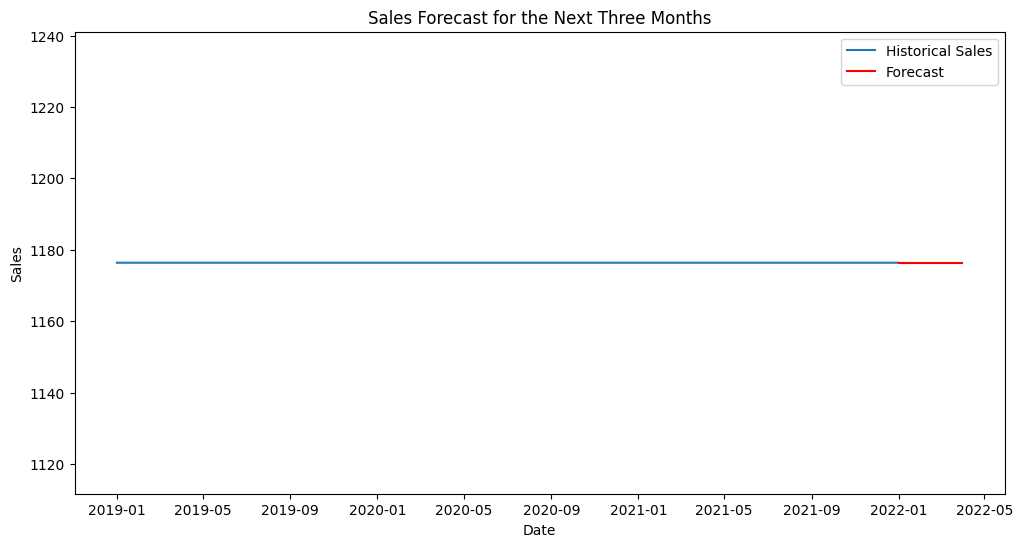

In [4]:
#Forecasting using Deep Learning Algorithm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load and prepare data
series = merged_df[['date', 'price']].set_index('date').resample('D').sum().fillna(0)
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(series)

# Split the series into training and testing sets
train_size = int(len(scaled_series) * 0.8)
train, test = scaled_series[:train_size], scaled_series[train_size:]

def create_lstm_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 30
X_train, y_train = create_lstm_dataset(train, look_back)
X_test, y_test = create_lstm_dataset(test, look_back)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build and train the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict using the model
y_pred_lstm = model.predict(X_test)

# Reshape and inverse transform predictions
y_pred_lstm = y_pred_lstm.reshape(-1, 1)
y_pred_lstm = np.concatenate((y_pred_lstm, np.zeros((y_pred_lstm.shape[0], 1))), axis=1)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)[:, 0]

# Reshape and inverse transform actual values
y_test = y_test.reshape(-1, 1)
y_test = np.concatenate((y_test, np.zeros((y_test.shape[0], 1))), axis=1)
y_test_inv = scaler.inverse_transform(y_test)[:, 0]

# Calculate MAPE
mape = np.mean(np.abs((y_test_inv - y_pred_lstm) / y_test_inv)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Train a model on the entire series for forecasting
X_all, y_all = create_lstm_dataset(scaled_series, look_back)
X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))

model_all = Sequential()
model_all.add(LSTM(50, input_shape=(look_back, 1)))
model_all.add(Dense(1))
model_all.compile(optimizer='adam', loss='mean_squared_error')
model_all.fit(X_all, y_all, epochs=20, batch_size=32, verbose=1)

# Forecast for the next three months
future_steps = 90
last_known = scaled_series[-look_back:].reshape((1, look_back, 1))
forecast = []

for _ in range(future_steps):
    prediction = model_all.predict(last_known)[0, 0]
    forecast.append(prediction)
    # Update `last_known` by removing the oldest value and appending the new prediction
    last_known = np.roll(last_known, shift=-1, axis=1)
    last_known[0, -1, 0] = prediction

# Inverse transform the forecast
forecast = np.array(forecast).reshape(-1, 1)
forecast = np.concatenate((forecast, np.zeros((forecast.shape[0], 1))), axis=1)
forecast = scaler.inverse_transform(forecast)[:, 0]

# Plot the forecast
future_dates = pd.date_range(start=series.index[-1] + pd.DateOffset(days=1), periods=future_steps)
plt.figure(figsize=(12, 6))
plt.plot(series.index, series['price'], label='Historical Sales')
plt.plot(future_dates, forecast, label='Forecast', color='red')
plt.title('Sales Forecast for the Next Three Months')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


